In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fname = 'train.csv'
df = pd.read_csv('preprocessed1_' + fname, index_col='Id')
n_examples, n_features = df.shape

pd.set_option('display.max_rows', 90)
pd.set_option("display.precision", 2)
print(f"Features: {n_features}")
print(f"Examples: {n_examples}")

Features: 33
Examples: 1460


## Checking for skewness and potential anomalies

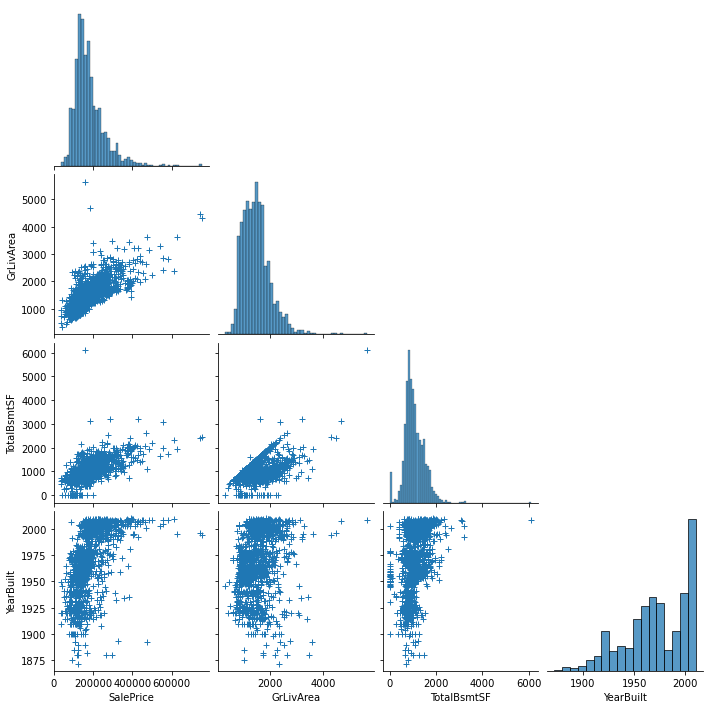

In [11]:
def pairplot(df, kde=False):
    g = sns.pairplot(data=df, plot_kws=dict(marker="+", linewidth=1), corner=True);
    if kde:
        g.map_lower(sns.kdeplot, levels=[0.1], color=".2");    

lst = ['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt'] 
pairplot(df[lst])

### Analysis:

- 'SalePrice', 'GrLiveArea', 'TotalBsmtSf' have skewed distribution. We apply log-transformation to make it look more symmetric.

- The scatterplots show the anomalies. We must find and remove them.

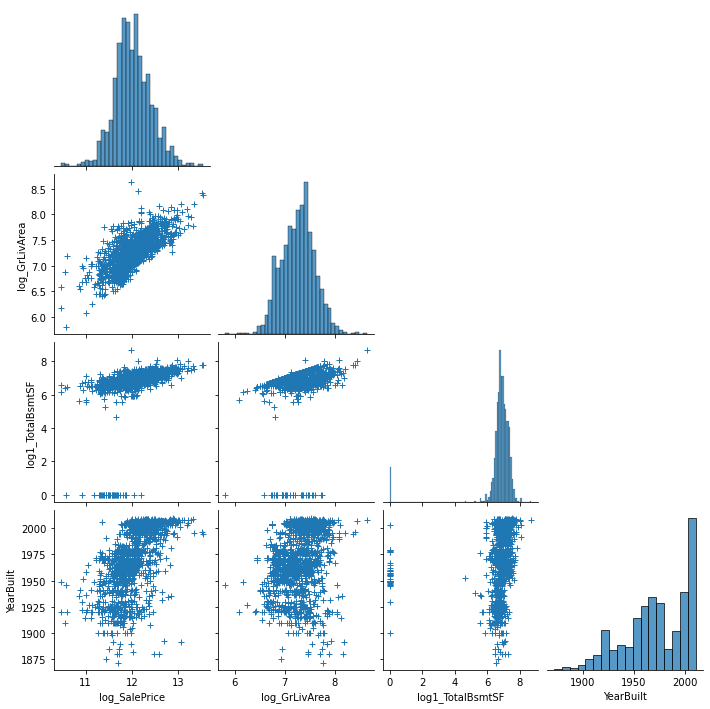

In [12]:
df.loc[:, 'SalePrice'] = np.log(df['SalePrice'])
df.loc[:, 'GrLivArea'] = np.log(df['GrLivArea'])
df.loc[:, 'TotalBsmtSF'] = df['TotalBsmtSF'].transform(lambda x: np.log(1 + x))

df = df.rename(columns={'SalePrice': 'log_SalePrice', 
                        'GrLivArea': 'log_GrLivArea',
                        'TotalBsmtSF': 'log1_TotalBsmtSF'})
lst = ['log_SalePrice', 'log_GrLivArea', 'log1_TotalBsmtSF', 'YearBuilt']

pairplot(df[lst])

## Anomalies detection

For each point in dataset we perform F-test with null hypothesis:

$$ H_0: x_i \text{ is not an anomaly}, \ \ \alpha = 0.001$$

We compute F-statistic:

$$ \hat{F}_i = \frac{(n-1)(n-1-q)D^2_i}{n (n-2)q} $$

where $D_i$ is Mahalanobis distance from $x_i$ to distribution.

p-value: $ p_i = P\{F > \hat{F}_i\} $

If $ p_i < \alpha$, then we reject null hypothesis. Therefore, $x_i$ is an anomaly.


In [4]:
from scipy.spatial.distance import mahalanobis
from scipy.stats import f
from numpy.linalg import inv


def mahalanobis_distances(data):
    n = data.shape[0]
    maha_distances = np.zeros(n)
    for i in range(n):
        x_i = data.iloc[i]
        data_i = data.drop(data.index[i])
        m_i = np.mean(data_i)
        inv_cov = inv(np.cov(data_i, rowvar=False))
        maha_distances[i] = mahalanobis(x_i, m_i, inv_cov)
    return maha_distances
  
    
# returns i,    if x_i is an anomaly
#         None, otherwise
def Ftest(data, alpha=0.01):
    maha_distances = mahalanobis_distances(data)  
    n, q = data.shape
    Fstat = (n-1)*(n-1-q)/(n*(n-2)*q) * maha_distances**2
    i_0 = np.argmax(Fstat)
    dfn, dfd = q, n-1-q
    F_alpha = f.ppf(1-alpha, dfn, dfd)
    p_value = 1-f.cdf(Fstat[i_0],  dfn, dfd)
    if Fstat[i_0] > F_alpha:
        print("{:4d} :     A, p-value = {:.2e}, where alpha = {:.2e}".format(data.index[i_0], p_value, alpha))
        return data.index[i_0]
    else:
        print("{:4d} : NOT A, p-value = {:.2e}, where alpha = {:.2e}".format(data.index[i_0], p_value, alpha))
        return None

    
# returns: df, anomalies        
def remove_anomalies(data, columns, alpha):
    anomalies = []
    anomalies_ind = []
    found = True
    while found:
        i_0 = Ftest(data[columns], alpha)
        found = bool(i_0)
        if found:
            anomalies.append(data[columns].loc[i_0].tolist())
            anomalies_ind.append(i_0)
            data = data.drop(i_0)
    return data, np.array(anomalies), anomalies_ind
            
    
df, anomalies_gr, anomalies_gr_ind = remove_anomalies(data=df, 
                                                columns=['log_SalePrice', 'log_GrLivArea'],
                                                alpha=1e-3)
data = df[df['log1_TotalBsmtSF'] > 0]
data, anomalies_tot, anomalies_tot_ind = remove_anomalies(data,
                                                    columns=['log_SalePrice', 'log1_TotalBsmtSF'],
                                                    alpha=1e-3)

print("Anomalies: ", anomalies_gr_ind + anomalies_tot_ind)
df.loc[df['log1_TotalBsmtSF'] > 0] = data
df = df.dropna()


1299 :     A, p-value = 5.69e-09, where alpha = 1.00e-03
  31 :     A, p-value = 3.38e-06, where alpha = 1.00e-03
 524 :     A, p-value = 3.25e-06, where alpha = 1.00e-03
 534 :     A, p-value = 4.99e-05, where alpha = 1.00e-03
 969 :     A, p-value = 5.86e-05, where alpha = 1.00e-03
1063 :     A, p-value = 1.25e-04, where alpha = 1.00e-03
 496 :     A, p-value = 1.60e-04, where alpha = 1.00e-03
 917 :     A, p-value = 3.09e-04, where alpha = 1.00e-03
1183 :     A, p-value = 4.02e-04, where alpha = 1.00e-03
 692 :     A, p-value = 3.86e-04, where alpha = 1.00e-03
1293 : NOT A, p-value = 1.02e-03, where alpha = 1.00e-03
 873 :     A, p-value = 1.32e-12, where alpha = 1.00e-03
 495 :     A, p-value = 2.44e-06, where alpha = 1.00e-03
 741 :     A, p-value = 4.72e-05, where alpha = 1.00e-03
 491 :     A, p-value = 1.01e-04, where alpha = 1.00e-03
 411 :     A, p-value = 3.23e-04, where alpha = 1.00e-03
 711 :     A, p-value = 3.66e-04, where alpha = 1.00e-03
 637 :     A, p-value = 3.66e-0

### Visualization

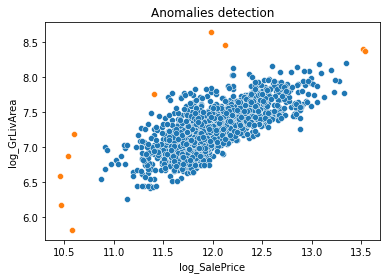

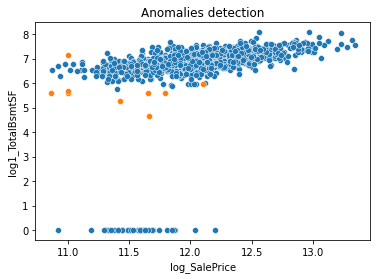

In [7]:
sns.scatterplot(data=df, x='log_SalePrice', y='log_GrLivArea')
sns.scatterplot(x=anomalies_gr[:, 0], y=anomalies_gr[:, 1]);
plt.title("Anomalies detection")
plt.show();

sns.scatterplot(data=df, x='log_SalePrice', y='log1_TotalBsmtSF')
sns.scatterplot(x=anomalies_tot[:, 0], y=anomalies_tot[:, 1])
plt.title("Anomalies detection");
plt.show();

## Summary

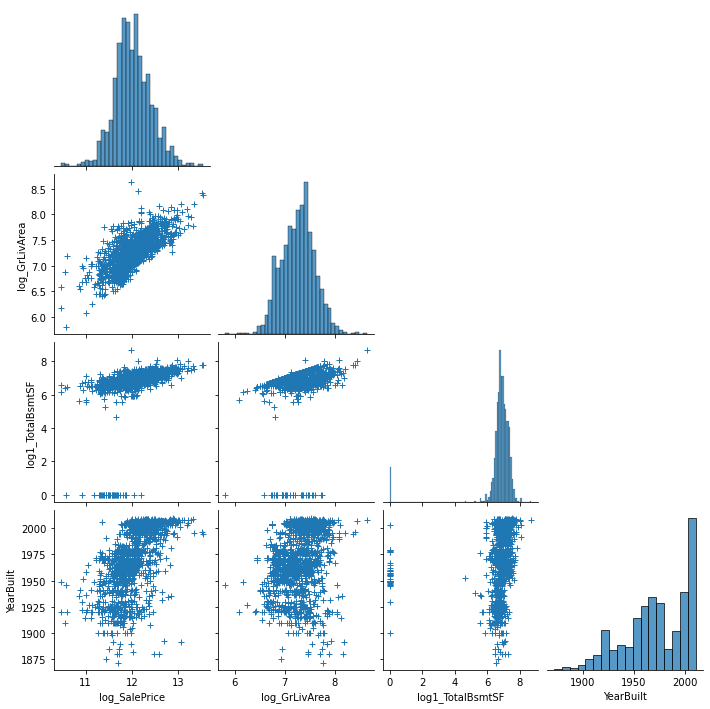

In [13]:
pairplot(df[lst])

## Saving results

In [15]:
df.to_csv('preprocessed2_' + fname)